## Example B.1 Level Breadth-first Search

Examples come from http://people.eecs.berkeley.edu/~aydin/GraphBLAS_API_C_v13.pdf

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import grblas as gb
from grblas import lib, ffi, Matrix, Vector, Scalar
from grblas.base import NULL, REPLACE
from grblas import dtypes
from grblas import descriptor
from grblas import UnaryOp, BinaryOp, Monoid, Semiring

In [2]:
def vrepr(v):
    df = pd.DataFrame(index=range(v.size), columns=[''])
    for i, val in zip(*v.to_values()):
        df.iloc[i] = val
    return df.where(pd.notnull(df), '')

def hrepr(v):
    return vrepr(v).T

def mrepr(m):
    df = pd.DataFrame(columns=range(m.ncols), index=range(m.nrows))
    for i, j, val in zip(*m.to_values()):
        df.iloc[i, j] = val
    return df.where(pd.notnull(df), '')

def draw(m):
    g = nx.DiGraph()
    for row, col, val in zip(*m.to_values()):
        g.add_edge(row, col, weight=val)
    pos = nx.spring_layout(g)
    edge_labels = {(i, j): d['weight'] for i, j, d in g.edges(data=True)}
    nx.draw_networkx(g, pos, node_color='red', node_size=500)
    #nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels)

In [3]:
# Create initial data objects
edges = [
    [3,0,3,5,6,0,6,1,6,2,4,1],
    [0,1,2,2,2,3,3,4,4,5,5,6],
]
A = Matrix.new_from_values(edges[0], 
                           edges[1],
                          [True for _ in edges[0]])
s = 1

In [4]:
mrepr(A)

,0,1,2,3,4,5,6
0,,True,,True,,,
1,,,,,True,,True
2,,,,,,True,
3,True,,True,,,,
4,,,,,,True,
5,,,True,,,,
6,,,True,True,True,,


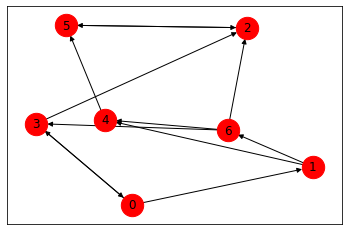

In [5]:
draw(A)

### level breadth-first search (BFS) in GraphBLAS
```
1 #include <stdlib.h>
2 #include <stdio.h>
3 #include <stdint.h>
4 #include <stdbool.h>
5 #include ”GraphBLAS.h”
6
7 /*
8  * Given a boolean n x n adjacency matrix A and a source vertex s, performs a BFS traversal
9  * of the graph and sets v[i] to the level in which vertex i is visited ( v[s] == 1 ).
10 * If i is not reacheable from s, then v[i] = 0. ( Vector v should be empty on input. )
11 */
12 GrB_Info BFS( GrB Vector *v , GrB Matrix A, GrB Index s )
13 {
14   GrB_Index n;
15   GrB_Matrix_nrows(&n, A); // n = # of rows of A
16
17   GrB_Vector_new(v, GrB_INT32, n); // Vector<int32_t> v(n)
18
19   GrB_Vector q; // vertices visited in each level
20   GrB_Vector_new(&q ,GrB_BOOL, n); // Vector<bool> q (n )
21   GrB_Vector_setElement(q , ( bool ) true , s ) ; // q[s] = true , false everywhere else
22
23   /*
24    * BFS traversal and label the vertices.
25    */
26   int32_t d = 0 ; // d = level in BFS traversal
27   bool succ = false ; // succ == true when some successor found
28   do {
29     ++d ; // next level ( startwith 1)
30     GrB_assign (*v, q, GrB_NULL, d, GrB_ALL, n, GrB_NULL ) ; // v[q] = d
31     GrB_vxm(q, *v, GrB_NULL, GrB_LOR_LAND_SEMIRING_BOOL,
32             q, A, GrB_DESC_RC); // q[!v] = q ||.&& A ; finds all the
33                                 // unvisited successors from current q
34     GrB_reduce(&succ, GrB_NULL, GrB_LOR_MONOID_BOOL,
35                q, GrB_NULL ) ; // succ = || ( q )
36   } while ( succ ) ; // if there is no successor in q, we are done.
37
38   GrB_free (&q) ; // q vector no longer needed
39
40   return GrB_SUCCESS ;
41 }
```

## Python implementation

In [6]:
n = A.nrows
v = Vector.new_from_type(dtypes.INT32, n)
q = Vector.new_from_type(bool, n)
q.element[s] = True
succ = Scalar.new_from_type(bool)

In [7]:
d = 0  # level in BFS traversal
while True:
    d += 1
    # For the frontier, assign the depth level
    v.assign[q] = d
    # Compute the next frontier, masking out anything already assigned
    q[~v, REPLACE] = q.vxm(A, Semiring.LOR_LAND)
    # If next frontier is empty, we're done
    succ[:] = q.reduce(Monoid.LOR)
    if not succ:
        break
hrepr(v)

,0,1,2,3,4,5,6
,4,1,3,3,2,3,2


Let's Step thru each loop to watch the action unfold

In [8]:
# Only run this cell once -- it initializes things
v.clear()
q.clear()
q.element[s] = True
d = 0

In [18]:
d += 1
# For the frontier, assign the depth level
v.assign[q] = d
hrepr(v)

,0,1,2,3,4,5,6
,4,1,3,3,2,3,2


In [19]:
# Compute the next frontier, masking out anything already assigned
q[~v, REPLACE] = q.vxm(A, Semiring.LOR_LAND)
hrepr(q)
# These are the next layer of the BFS, prep'd for the next iteration

,0,1,2,3,4,5,6
,,,,,,,


In [20]:
succ[:] = q.reduce(Monoid.LOR)
print('Continue' if succ else 'Done')

Done
